In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
torch.set_default_dtype(torch.float64)
import torch.nn as nn
import copy
import random

In [3]:
import config as cfg
from model import DeepNN
from utils import relative_l2, set_seed
from train_reg import train_model_reg
from train_pde import train_model_pde

In [4]:
set_seed(0)
model_E = DeepNN().cuda()
model_T = DeepNN().cuda()
[model_E, model_T] = train_model_reg(model_E, model_T, Nfit=300, lr_E=1e-3, lr_T=1e-3)

E: lbfgs : 0 - ref_rl2 6.1604e-01 
T: lbfgs : 0 - ref_rl2 8.2804e-01 
E: lbfgs : 50 - ref_rl2 3.1278e-03 
T: lbfgs : 50 - ref_rl2 1.6980e-03 
E: lbfgs : 100 - ref_rl2 7.2896e-04 
T: lbfgs : 100 - ref_rl2 1.5058e-04 
E: lbfgs : 150 - ref_rl2 1.7102e-04 
T: lbfgs : 150 - ref_rl2 7.4940e-05 
E: lbfgs : 200 - ref_rl2 1.3613e-04 
T: lbfgs : 200 - ref_rl2 6.1778e-05 
E: lbfgs : 250 - ref_rl2 1.2618e-04 
T: lbfgs : 250 - ref_rl2 5.6277e-05 
E: lbfgs : 299 - ref_rl2 1.2102e-04 
T: lbfgs : 299 - ref_rl2 5.3335e-05 


In [5]:
set_seed(50)
model_E_cur = DeepNN().cuda()
model_E_cur.load_state_dict(copy.deepcopy(model_E.state_dict()))
model_T_cur = DeepNN().cuda()
model_T_cur.load_state_dict(copy.deepcopy(model_T.state_dict()))
[model_E_cur, model_T_cur] = train_model_pde(model_E_cur, model_T_cur, Nfit=200, lr_E=1e-1, lr_T=1e-1)

E: adam : 0 - ref_rl2 1.2518e-04 - pde 1.6407e-05 - lbc 5.6135e-03 - rbc 1.8211e-06 - tbc 2.1028e+00 - bbc 7.2296e-03
T: adam : 0 - ref_rl2 5.4104e-05 - pde 2.4098e-05 - lbc 4.8231e-05 - rbc 2.9343e-02 - tbc 3.6617e-03 - bbc 5.7966e-05
E: adam : 10 - ref_rl2 7.1722e-05 - pde 1.6510e-05 - lbc 3.0172e-03 - rbc 7.3573e-07 - tbc 7.0705e-01 - bbc 3.5027e-03
T: adam : 10 - ref_rl2 4.1315e-06 - pde 1.7174e-05 - lbc 2.4397e-06 - rbc 3.1007e-02 - tbc 1.1185e-04 - bbc 4.4748e-06
E: adam : 20 - ref_rl2 2.3707e-05 - pde 1.6629e-05 - lbc 4.1352e-04 - rbc 5.6293e-07 - tbc 5.1727e-01 - bbc 3.5392e-04
T: adam : 20 - ref_rl2 2.7352e-06 - pde 1.6979e-05 - lbc 1.3538e-06 - rbc 3.1071e-02 - tbc 2.5156e-05 - bbc 1.9437e-06
E: adam : 30 - ref_rl2 1.2201e-05 - pde 1.6663e-05 - lbc 6.6164e-05 - rbc 4.7928e-07 - tbc 2.9000e-01 - bbc 3.2832e-05
T: adam : 30 - ref_rl2 2.7200e-06 - pde 1.6977e-05 - lbc 1.3688e-06 - rbc 3.1066e-02 - tbc 2.5011e-05 - bbc 1.9662e-06
E: adam : 40 - ref_rl2 9.3735e-06 - pde 1.6671e-05

In [6]:
X = cfg.X.detach().cpu()
Y = cfg.Y.detach().cpu()
E_reg = model_E(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
E_pinn = model_E_cur(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
E_ref = cfg.E_ref.cpu()
T_reg = model_T(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
T_pinn = model_T_cur(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
T_ref = cfg.T_ref.cpu()

In [7]:
print('E: Regression Solution rl2: {:.4e}'.format(relative_l2(E_ref, E_reg)))
print('E: PINN Solution rl2: {:.4e}'.format(relative_l2(E_ref, E_pinn)))

print('T: Regression Solution rl2: {:.4e}'.format(relative_l2(T_ref, T_reg)))
print('T: PINN Solution rl2: {:.4e}'.format(relative_l2(T_ref, T_pinn)))

E: Regression Solution rl2: 1.2102e-04
E: PINN Solution rl2: 7.9144e-06
T: Regression Solution rl2: 5.3335e-05
T: PINN Solution rl2: 2.6790e-06


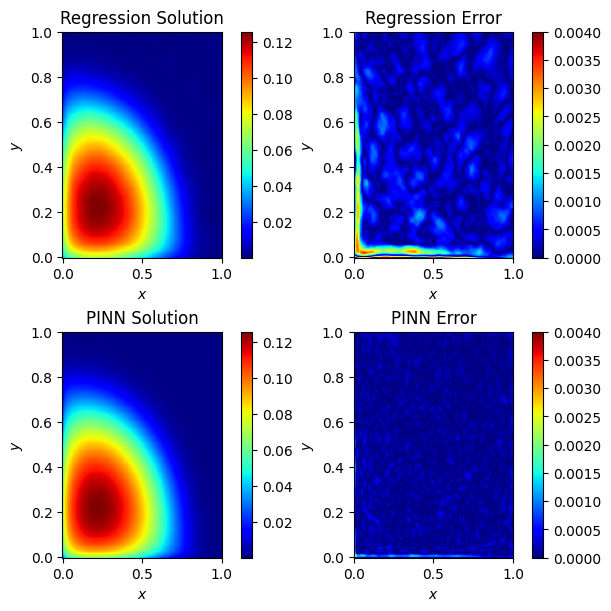

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), layout='constrained')

vmin = E_ref.min()
vmax = E_ref.max()

pcm = axs[0][0].pcolormesh(X, Y, E_reg, vmin=vmin, vmax=vmax, cmap='jet')
axs[0][0].set_title("Regression Solution")
axs[0][0].set_xlabel("$x$")
axs[0][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][0])

pcm = axs[0][1].pcolormesh(X, Y, (E_ref - E_reg).abs(), vmin=0, vmax=0.004, cmap='jet')
axs[0][1].set_title("Regression Error")
axs[0][1].set_xlabel("$x$")
axs[0][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][1])

pcm = axs[1][0].pcolormesh(X, Y, E_pinn, vmin=vmin, vmax=vmax, cmap='jet')
axs[1][0].set_title("PINN Solution")
axs[1][0].set_xlabel("$x$")
axs[1][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][0])

pcm = axs[1][1].pcolormesh(X, Y, (E_ref - E_pinn).abs(), vmin=0, vmax=0.004, cmap='jet')
axs[1][1].set_title("PINN Error")
axs[1][1].set_xlabel("$x$")
axs[1][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][1])

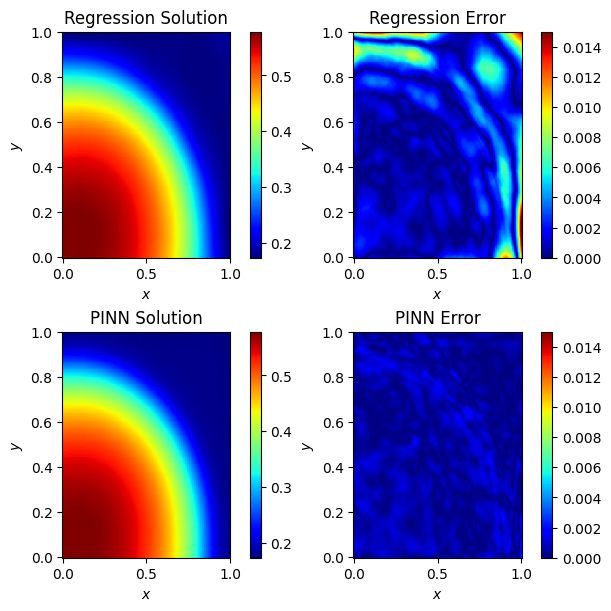

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), layout='constrained')

vmin = T_ref.min()
vmax = T_ref.max()

pcm = axs[0][0].pcolormesh(X, Y, T_reg, vmin=vmin, vmax=vmax, cmap='jet')
axs[0][0].set_title("Regression Solution")
axs[0][0].set_xlabel("$x$")
axs[0][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][0])

pcm = axs[0][1].pcolormesh(X, Y, (T_ref - T_reg).abs(), vmin=0, vmax=0.015, cmap='jet')
axs[0][1].set_title("Regression Error")
axs[0][1].set_xlabel("$x$")
axs[0][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][1])

pcm = axs[1][0].pcolormesh(X, Y, T_pinn, vmin=vmin, vmax=vmax, cmap='jet')
axs[1][0].set_title("PINN Solution")
axs[1][0].set_xlabel("$x$")
axs[1][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][0])

pcm = axs[1][1].pcolormesh(X, Y, (T_ref - T_pinn).abs(), vmin=0, vmax=0.015, cmap='jet')
axs[1][1].set_title("PINN Error")
axs[1][1].set_xlabel("$x$")
axs[1][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][1])